# House Price Prediction

Another training dataset on Kaggle, this time this is regression problem, price of a house has to be predicted using 79 features, among them 36 are numerical. The highest score achieved here is 0.12893, in the top half. Four models are tested:
* Elastic Net
* Gradient Boosting
* Random Forest
* kNN

On cross validation and test set Gradient Boosting is the best model, Random Forest performs better on cross validation, but Elastic Net is better on test set. kNN performs really poor. But the best result gives equally weighted sum of Gradient Boosting, Random Forest and Elastic Net. 

In [18]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [9]:
# importing datasets
df = pd.read_csv('train.csv', index_col = 'Id')
df_test = pd.read_csv('test.csv', index_col = 'Id')
y_train = df['SalePrice'].values
print(df.shape, df_test.shape)
df.head(20)

(1460, 80) (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


In [10]:
# numerical features
df_num = df.select_dtypes(exclude = ['object'])
df_cat = df.select_dtypes(include = ['object'])

df_test_num = df_test.select_dtypes(exclude = ['object'])
df_test_cat = df_test.select_dtypes(include = ['object'])

df_num.describe()

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,NaN,7553.500000,5.000000,5.000000,1954.000000,1967.000000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,NaN,9478.500000,6.000000,5.000000,1973.000000,1994.000000,NaN,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,NaN,11601.500000,7.000000,6.000000,2000.000000,2004.000000,NaN,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Categorical features

There aren't features with many categories, so dummmy features creation is used, nevertheless there are four features, where more than half values are missing, so for them another category 'Unknown' is created, and for others missing values are replaced by the most common category.

In [11]:
for feature in df_cat.columns:
    if feature in ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']:
        df_cat[feature].fillna('Unknown', inplace = True)
        df_test_cat[feature].fillna('Unknown', inplace = True)

df_cat.describe()

//anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,1460,1460,1460,1460,1460
unique,5,2,3,4,4,2,5,3,25,9,...,6,3,5,5,3,4,5,5,9,6
top,RL,Pave,Unknown,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Unknown,Unknown,Unknown,WD,Normal
freq,1151,1454,1369,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,1453,1179,1406,1267,1198


In [12]:
df_cat = df_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))
df_test_cat = df_test_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))
df_all = pd.concat([df_cat, df_test_cat])
df_all_dummies = pd.get_dummies(df_all)
df_dummies = df_all_dummies.iloc[:len(df),:]
df_test_dummies = df_all_dummies.iloc[len(df):,:]
print(df_dummies.shape, df_test_dummies.shape)

(1460, 257) (1459, 257)


# Exploratory analysis

Here only analysis for numerical features is made, we see, that there are few highly correlated features, but there aren't features highly correlated with house price (there are no features with correlation over 0.8). For top ten most correlated with price features, pairplot is made.

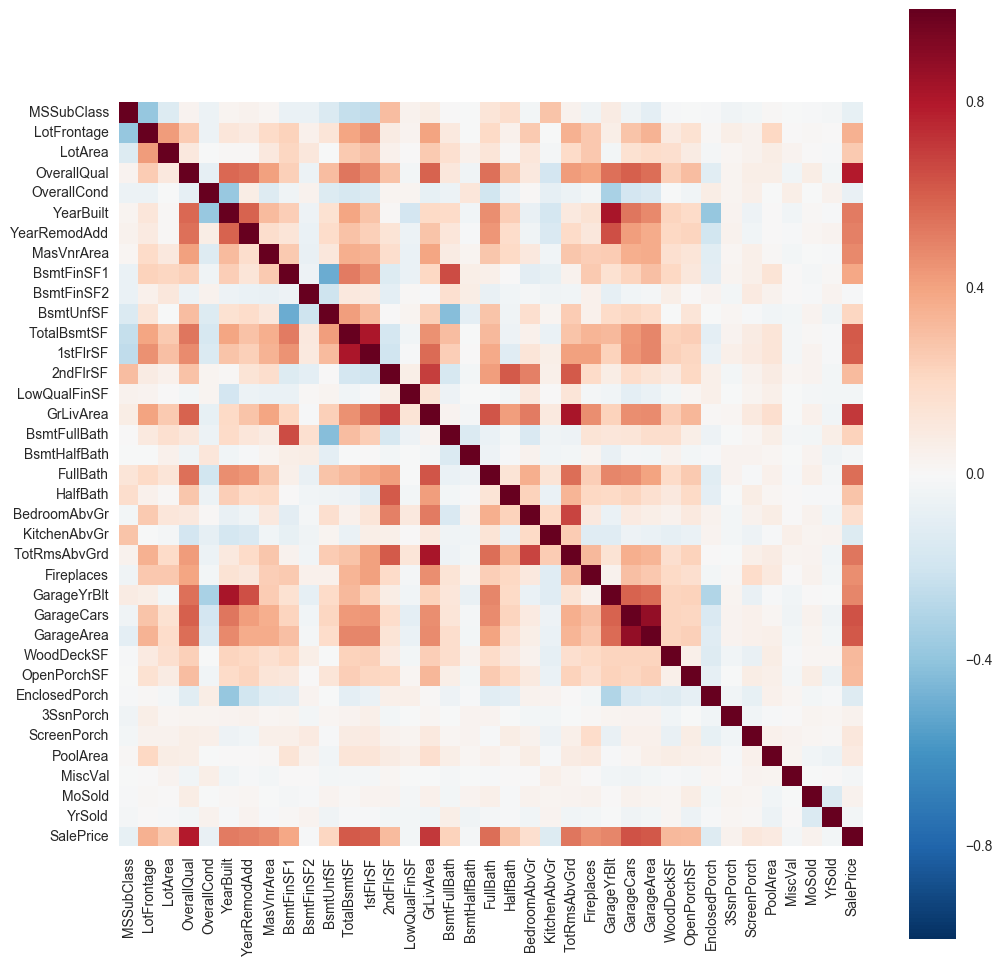

In [37]:
plt.figure(figsize = (12, 12))
seaborn.heatmap(df_num.corr(), square = True)

In [38]:
df_num.corr().iloc[-1,:].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

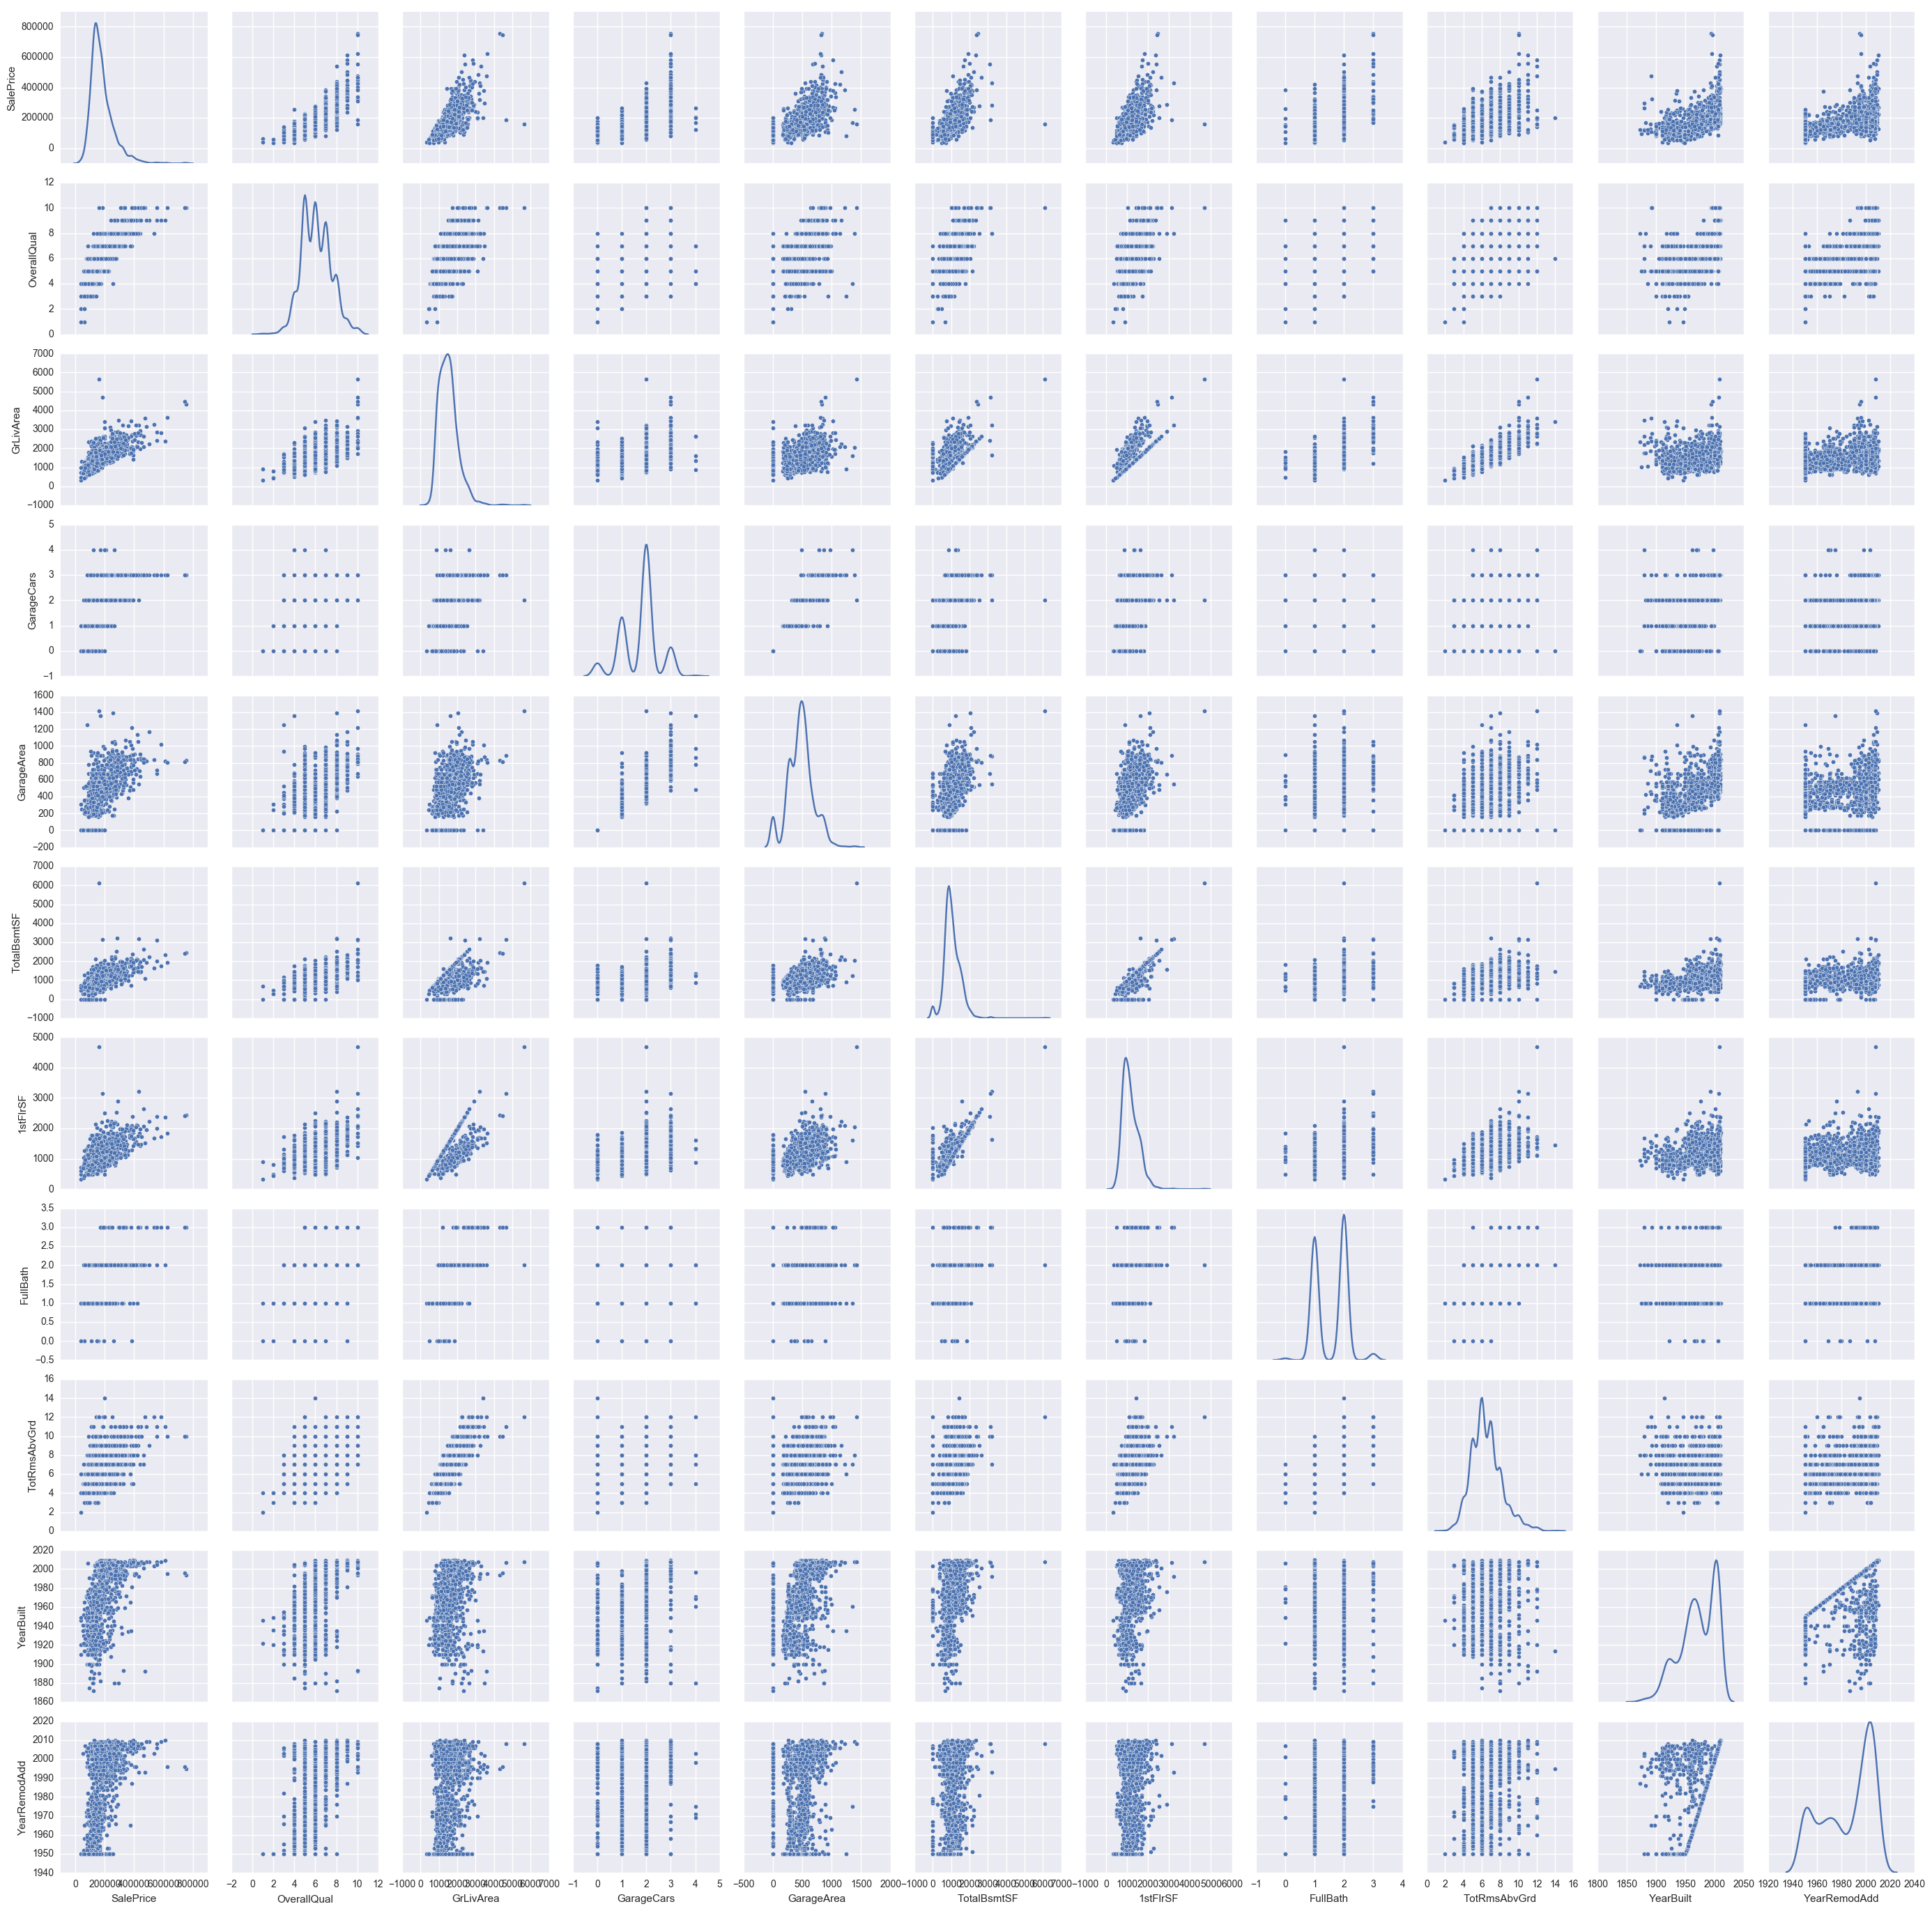

In [39]:
max_index = list(df_num.corr().iloc[-1,:].sort_values(ascending = False).index[:11])
seaborn.pairplot(df_num[max_index], diag_kind = 'kde')

In [13]:
df_num.drop('SalePrice', axis = 1, inplace = True)
X_train = np.concatenate((df_num.values, df_dummies.values), axis = 1)
X_test = np.concatenate((df_test_num.values, df_test_dummies.values), axis = 1)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Baseline models

We built four baseline models here: Linear Regression, Gradient Booosting, Random Forest and kNN. As we see, Gradient Boosting and Random Forest are the best, and kNN is really poor. 

In [16]:
kf = KFold(n_splits = 4, shuffle = True, random_state = 147)
pipe_lr = Pipeline([('imputer', Imputer()), ('linreg', LinearRegression())])
pipe_gb = Pipeline([('imputer', Imputer()), ('gb_reg', GradientBoostingRegressor(random_state = 147))])
pipe_rf = Pipeline([('imputer', Imputer()), ('rf_reg', RandomForestRegressor(n_estimators = 50, random_state = 147))])
pipe_knn = Pipeline([('imputer', Imputer()), ('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor())])

lr_score = np.mean(cross_val_score(pipe_lr, X_train, y_train, cv = kf, scoring = 'r2'))
gb_score = np.mean(cross_val_score(pipe_gb, X_train, y_train, cv = kf, scoring = 'r2'))
rf_score = np.mean(cross_val_score(pipe_rf, X_train, y_train, cv = kf, scoring = 'r2'))
knn_score = np.mean(cross_val_score(pipe_knn, X_train, y_train, cv = kf, scoring = 'r2'))
print(lr_score, gb_score, rf_score, knn_score)

0.756602803845 0.884606727871 0.856046914382 0.729267735492


## Hyperparameters tuning

So for every model we make hyperparameters tuning, we see, that the best improvement is for Linear Regression, where adding l2 and l1 regularization improves $R^2$ score from 0.757 to 0.821 

In [32]:
pipe_en = Pipeline([('imputer', Imputer()), ('scaler', StandardScaler()), ('enreg', ElasticNet())])
grid_en = {'imputer__strategy': ['mean', 'median', 'most_frequent'],
           'enreg__alpha': [0.1, 0.3, 1, 3, 10],
           'enreg__l1_ratio': [0.1, 0.125, 0.15, 0.175, 0.2]}
gs_en = GridSearchCV(pipe_en, grid_en, cv = kf, scoring = 'r2')
gs_en.fit(X_train, y_train)
print(gs_en.best_score_, gs_en.best_params_)

0.821406929231 {'enreg__alpha': 1, 'enreg__l1_ratio': 0.175, 'imputer__strategy': 'most_frequent'}


In [34]:
pipe_gb = Pipeline([('imputer', Imputer()), ('gb_reg', GradientBoostingRegressor(random_state = 147))])
grid_gb = {'imputer__strategy': ['mean', 'median', 'most_frequent'],
           'gb_reg__learning_rate': [0.2, 0.25, 0.3],
           'gb_reg__n_estimators': [350, 400, 450, 500],
           'gb_reg__max_depth': [2, 3, 4]}
gs_gb = GridSearchCV(pipe_gb, grid_gb, cv = kf, scoring = 'r2')
gs_gb.fit(X_train, y_train)
print(gs_gb.best_score_, gs_gb.best_params_)

0.900442242251 {'gb_reg__n_estimators': 500, 'gb_reg__max_depth': 2, 'gb_reg__learning_rate': 0.25, 'imputer__strategy': 'median'}


In [36]:
pipe_rf = Pipeline([('imputer', Imputer()), ('rf_reg', RandomForestRegressor(random_state = 147))])
grid_rf = {'imputer__strategy': ['mean', 'median', 'most_frequent'],
           'rf_reg__n_estimators': [200, 210, 225, 240, 250],
           'rf_reg__max_features': ['auto', 'sqrt', 'log2']}
gs_rf = GridSearchCV(pipe_rf, grid_rf, cv = kf, scoring = 'r2')
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_, gs_rf.best_params_)

0.857338988623 {'rf_reg__max_features': 'auto', 'rf_reg__n_estimators': 225, 'imputer__strategy': 'median'}


In [28]:
pipe_knn = Pipeline([('imputer', Imputer()), ('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor())])
grid_knn = {'imputer__strategy': ['mean', 'median', 'most_frequent'],
            'knn__n_neighbors': [1, 3, 5, 7, 9, 15, 25, 49],
            'knn__weights': ['uniform', 'distance'],
            'knn__p': [1, 2]}
gs_knn = GridSearchCV(pipe_knn, grid_knn, cv = kf, scoring = 'r2')
gs_knn.fit(X_train, y_train)
print(gs_knn.best_score_, gs_knn.best_params_)

0.752755382835 {'knn__p': 1, 'knn__n_neighbors': 5, 'knn__weights': 'distance', 'imputer__strategy': 'most_frequent'}


## Feature Selection

We use SelectFromModel to select the most important features, this allows us to reduce the number of features considerably, and to improve $R^2$ score on cross validation for Elastic Net and Gradient Boosting. Random Forest performs poorer, but it uses only 22 features instead of 293.

In [68]:
imp1 = Imputer(strategy = 'most_frequent')
imp2 = Imputer(strategy = 'median')
scaler = StandardScaler()

X_train_en = scaler.fit_transform(imp1.fit_transform(X_train))
X_test_en = scaler.transform(imp1.transform(X_test))
X_train_gb = imp2.fit_transform(X_train)
X_test_gb = imp2.transform(X_test)
X_train_rf = imp2.fit_transform(X_train)
X_test_rf = imp2.transform(X_test)

en_reg = ElasticNet(alpha = 1, l1_ratio = 0.175)
gb_reg = GradientBoostingRegressor(n_estimators = 500, max_depth = 2, learning_rate = 0.25, random_state = 147)
rf_reg = RandomForestRegressor(max_features = 'auto', n_estimators = 225, random_state = 147)

en_reg.fit(X_train_en, y_train)
gb_reg.fit(X_train_gb, y_train)
rf_reg.fit(X_train_rf, y_train)

model_en = SelectFromModel(en_reg, prefit = True)
model_gb = SelectFromModel(gb_reg, prefit = True)
model_rf = SelectFromModel(rf_reg, prefit = True)

X_train_en = model_en.transform(X_train_en)
X_test_en = model_en.transform(X_test_en)
X_train_gb = model_gb.transform(X_train_gb)
X_test_gb = model_gb.transform(X_test_gb)
X_train_rf = model_rf.transform(X_train_rf)
X_test_rf = model_rf.transform(X_test_rf)

score_en = np.mean(cross_val_score(en_reg, X_train_en, y_train, cv = kf, scoring = 'r2'))
score_gb = np.mean(cross_val_score(gb_reg, X_train_gb, y_train, cv = kf, scoring = 'r2'))
score_rf = np.mean(cross_val_score(rf_reg, X_train_rf, y_train, cv = kf, scoring = 'r2'))
print(X_train_en.shape, X_train_gb.shape, X_train_rf.shape, X_test_en.shape, X_test_gb.shape, X_test_rf.shape, 
      score_en, score_gb, score_rf)

(1460, 85) (1460, 57) (1460, 22) (1459, 85) (1459, 57) (1459, 22) 0.841826801531 0.901760414117 0.855346559325


## Final results

Though with feature selection results are better on cross validation, on test set all features performs slightly better. And the best result is weighted sum of three models. There are a lot of ways of improvement, but I stop here, my result in top half, score is below 0.13, not bad at all.

In [79]:
y_pred = (gs_en.predict(X_test) + gs_gb.predict(X_test) + gs_rf.predict(X_test)) / 3
#en_reg.fit(X_train_en, y_train)
#gb_reg.fit(X_train_gb, y_train)
#rf_reg.fit(X_train_rf, y_train)
#y_pred = (en_reg.predict(X_test_en) + gb_reg.predict(X_test_gb) + rf_reg.predict(X_test_rf)) / 3
df_test['SalePrice'] = y_pred
df_test[['SalePrice']].to_csv('prediction.csv', sep = ',', header = True, index = True)

<img src='result.PNG'>